In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [79]:

df_oct = pd.read_csv('C:/Users/manue/desktop/personal_dir/La_Sapienza/ADM/HW02/2019-Oct.csv', header = 'infer', nrows = 1000000)
df_nov = pd.read_csv('C:/Users/manue/desktop/personal_dir/La_Sapienza/ADM/HW02/2019-Nov.csv', header = 'infer', nrows = 1000000)
df = pd.concat([df_oct, df_nov]).reset_index()

In [113]:
#filter event_type 'purchase' only, drop Nan products

purchases = df[df['event_type']=='purchase']
purchases = purchases.dropna(subset=['brand'])
purchases['event_time'] = pd.to_datetime(df.event_time)
purchases['event_time'] = purchases.event_time.dt.to_period("M")
purchases['event_time'] = purchases.event_time.dt.strftime('%Y-%m')

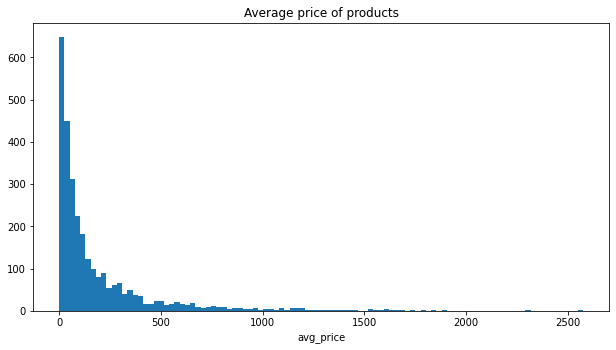

In [40]:
# average price of products

df_unique_products = df.drop_duplicates(subset=['product_id'])
avg_price = df_unique_products.groupby('brand')['price'].mean().reset_index()
avg_price.rename(columns={'index':'brand'}, inplace=True)
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)
ax = fig.add_axes([0,0,1,1])
ax.hist(avg_price.price, bins= 100)
plt.title('Average price of products')
plt.xlabel('avg_price')
plt.show()


In [114]:
def my_funct(df, mode = 0):
    if mode == 0:    
        brand = input('Select a brand:\n')
        brand_df = df.loc[df['brand'] == brand]
        profit_df = brand_df.groupby('event_time')['price'].sum().reset_index()
        #profit_df = brand_df.groupby(by = [brand_df.event_time.dt.year, brand_df.event_time.dt.month])['price'].sum().rename_axis(['year', 'month']).reset_index()
        profit_df = profit_df.rename(columns={'price': 'profit'})
        return profit_df
    else:
        profit_delta = pd.pivot_table(df, values='price', index=['brand'],
                    columns=[df.event_time], aggfunc=np.sum).reset_index()
        profit_delta.fillna(0, inplace=True)
        profit_delta['delta_num'] = profit_delta['2019-11'] - profit_delta['2019-10']
        profit_delta['delta_perc'] = profit_delta['delta_num'] / profit_delta['2019-10']
        return profit_delta.sort_values(by=['delta_perc','delta_num'], ascending = False)[:3]


my_funct(purchases, mode = 0)

,event_time,profit
0,2019-10,1102106.53
1,2019-11,1107752.48


In [5]:
# brand profit per month, version 1

def get_brand_profit(df, brand = None, mode = 0):
    if brand is None:
        brand = input('Select a brand:\n')
        mode = 1
    brand_df = df.loc[df['brand'] == brand]
    months = sorted(brand_df['event_time'].dt.month.unique())
    result = [brand, 0, 0]
    for month in months:
        if month == 10:
            result[1] = brand_df.loc[(df['brand'] == brand) & (df['event_time'].dt.month == month)].price.sum()
        else:
            result[2] = brand_df.loc[(df['brand'] == brand) & (df['event_time'].dt.month == month)].price.sum()
    result.append(result[2]-result[1])
    try:
        delta_perc = result[3]/result[1]
    except ZeroDivisionError:
        delta_perc = 1
    result.append(delta_perc)
    if mode == 1:
        print(f"Brand {brand} sales for Oct-2019: {result[1]:,.2f}. For Nov-2019: {result[2]:,.2f}")
        return None          
    return result


# top 3 brands w/ worst losses between the two months


def get_worst_losses(df):
    brands = df.brand.unique()
    performance = []
    for brand in brands:
        performance.append(get_brand_profit(df,brand))
    return sorted(performance, key = lambda x: x[4])[:3]


def print_worst_losses(df):
    my_list = get_worst_losses(df)
    for i in range(3):
        print(f"Brand {my_list[i][0]} lost {-my_list[i][4]:.2%} percent between Oct-2019 and Nov-2019")

In [6]:
# get profit for a specific brand for each month

get_brand_profit(purchases)

Select a brand:
 acer


Brand acer sales for Oct-2019: 84,198.60. For Nov-2019: 67,253.76


In [7]:
# get brands with the worst losses between Oct-2019 and Nov-2019 

print_worst_losses(purchases)

C:\Users\manue\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


Brand pdw lost 100.00% percent between Oct-2019 and Nov-2019
Brand ersport lost 100.00% percent between Oct-2019 and Nov-2019
Brand shimano lost 100.00% percent between Oct-2019 and Nov-2019


In [8]:
#get profit for a specific brand for each month, version 2

def get_brand_profit2(df):
    brand = input('Select a brand:\n')
    brand_df = df.loc[df['brand'] == brand]
    return brand_df.groupby(by= [brand_df.event_time.dt.year,brand_df.event_time.dt.month]).price.sum()

get_brand_profit2(purchases)

Select a brand:
 acer


event_time  event_time
2019        10            84198.60
            11            67253.76
Name: price, dtype: float64